In [1]:
import math
import random
import functools

import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, Optional

from scipy.stats import bernoulli

# Cracks Augmentation
Old photographs seem to have cracks and folds often, so if we want to fix this using deep learning, we have to make appropriate data augmentations.

In [2]:
def get_cracks(size: Tuple[int, int], *, simple_fork: bool = True, **kwargs) -> Tuple[np.ndarray, float]:
    assert len(size) == 2
    assert size[0] > 0 and size[1] > 0

    mtx = np.zeros(size, dtype=np.uint8)

    def stain(x_: float, y_: float) -> None:
        x_, y_ = int(x_), int(y_)
        x_ = abs(x_) % size[0]
        y_ = abs(y_) % size[1]
        mtx[x_, y_] = 1

    # Draw a crack and return its length
    def crack(x_: float, y_: float, angle: float, angle_amp: float = math.pi / 6, angle_dist: float = 10.0,
              fork_dist: float = 100.0, end_dist: float = 1000.0, end_dist_factor: float = 0.1,
              exact_end_dist: Optional[int] = None, exact_end_fork_factor: float = 0.25, step: float = 1.0) -> float:
        dist: float = 0.0
        forks_length: float = 0.0
        while True:
            angle_p = math.exp(-1 * dist / angle_dist)
            fork_p = math.exp(-1 * dist / fork_dist)
            end_p = math.exp(-1 * dist / end_dist)
            
            # Decide either to end the crack or not
            if exact_end_dist is None:
                # End the crack with probability (1 - end_p)
                if bernoulli.rvs(1 - end_p):
                    break
            else:
                if dist + forks_length > exact_end_dist:
                    break
            
            # Decide either to fork the crack or not
            if bernoulli.rvs(1 - fork_p):
                if simple_fork:
                    # Fork a new crack perpendicularly
                    cc_angle = angle + random.choice([-1, 1]) * math.pi / 2
                else:
                    # Fork a new crack in a different direction and
                    # alter the current crack's propagation angle too
                    angle_delta = random.uniform(-1, 1) * angle_amp
                    angle = angle + angle_delta
                    cc_angle = angle - angle_delta
                cc_end_dist = end_dist * end_dist_factor
                cc_exact_end_dist = (None
                                     if exact_end_dist is None else
                                     (exact_end_dist - dist - forks_length) * exact_end_fork_factor)
                forks_length += crack(x_, y_, angle=cc_angle, end_dist=cc_end_dist, exact_end_dist=cc_exact_end_dist)
            
            # Changes angle of the crack propagation with probability of (1 - angle_p)
            if bernoulli.rvs(1 - angle_p):
                angle += random.uniform(-1, 1) * angle_amp
            
            x_ += step * math.cos(angle)
            y_ += step * math.sin(angle)
            dist += step
            stain(x_, y_)
        return dist + forks_length
    
    x = random.randrange(0, size[0])
    y = random.randrange(0, size[1])
    angle = 2 * math.pi * random.random()
    length = crack(x, y, angle, **kwargs)
    return mtx, length
        

In [3]:
def plot_cracks(nrows_: int = 5, ncols_: int = 5, **kwargs) -> None:
    assert nrows_ > 1 and ncols_ > 1
    _, axes = plt.subplots(nrows=nrows_, ncols=ncols_, sharex=True, sharey=True, figsize=(12, 12))
    for i in range(nrows_):
        for j in range(ncols_):
            m, l = get_cracks((100, 100), **kwargs)
            plt.sca(ax=axes[i][j])
            plt.title(f'{l:.2f}')
            plt.imshow(m)


CPU times: user 590 ms, sys: 2.06 ms, total: 592 ms
Wall time: 612 ms


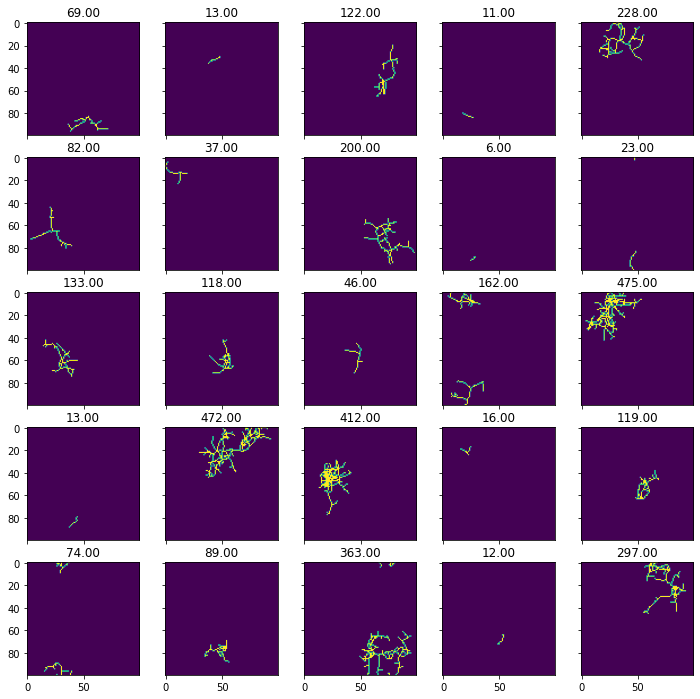

In [4]:
%%time
plot_cracks()

CPU times: user 1.01 s, sys: 6.82 ms, total: 1.02 s
Wall time: 1.02 s


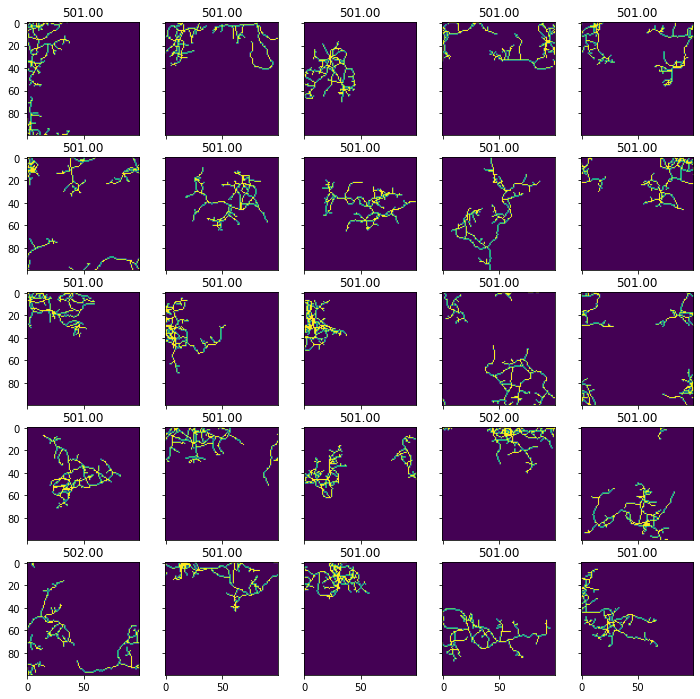

In [5]:
%%time
plot_cracks(fork_dist=1000, exact_end_dist=500)

CPU times: user 1 s, sys: 3.01 ms, total: 1 s
Wall time: 1 s


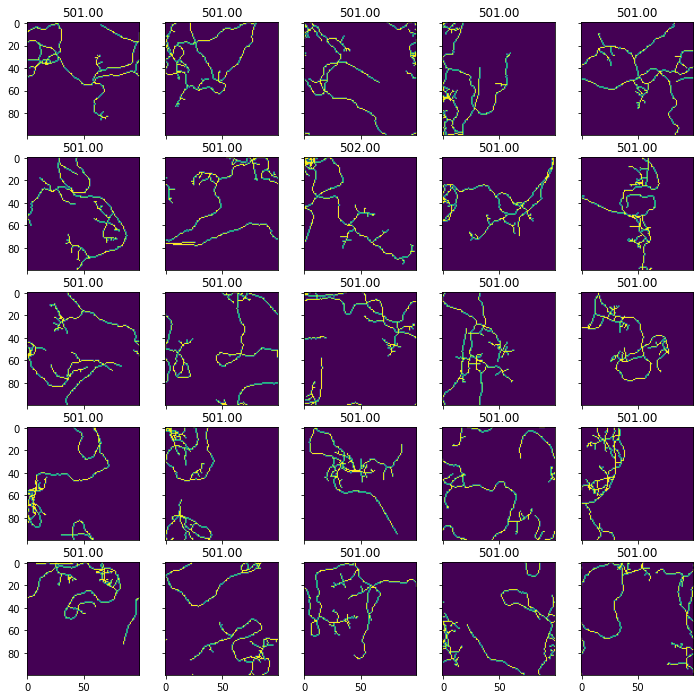

In [6]:
%%time
plot_cracks(angle_dist=100, fork_dist=10000, exact_end_dist=500)

CPU times: user 998 ms, sys: 0 ns, total: 998 ms
Wall time: 996 ms


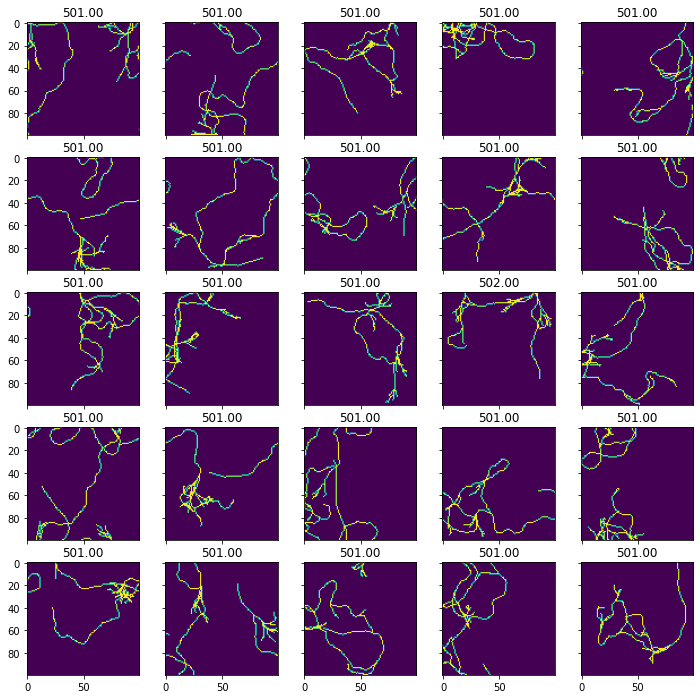

In [7]:
%%time
plot_cracks(simple_fork=False, angle_dist=100, fork_dist=10000, exact_end_dist=500)

CPU times: user 846 ms, sys: 0 ns, total: 846 ms
Wall time: 843 ms


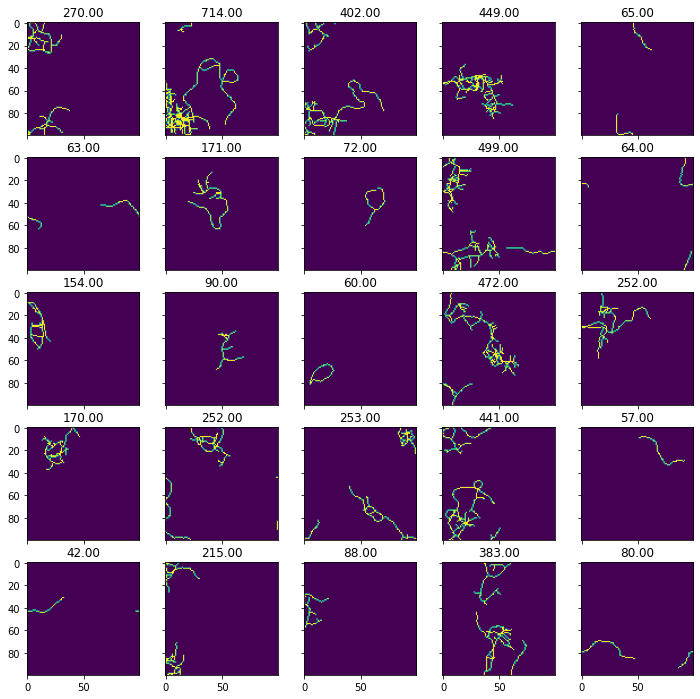

In [8]:
%%time
plot_cracks(fork_dist=2000, end_dist=5000)

CPU times: user 903 ms, sys: 3.64 ms, total: 906 ms
Wall time: 907 ms


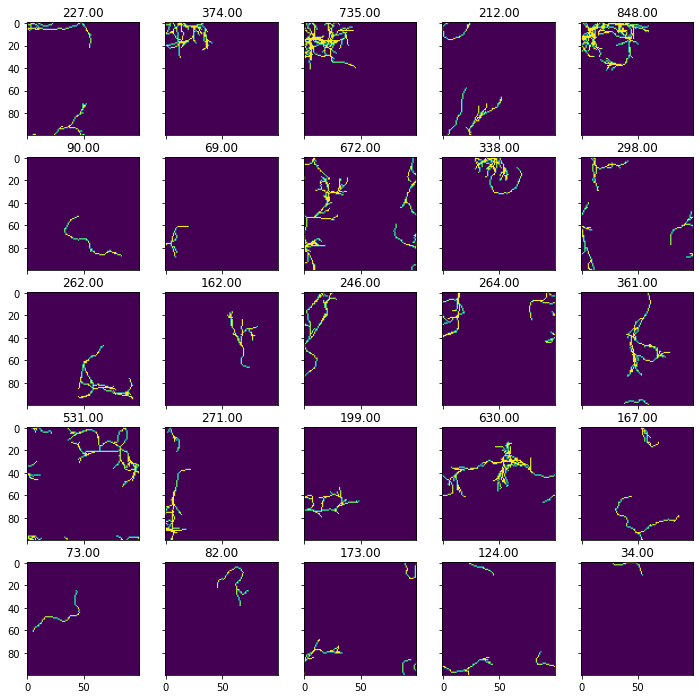

In [9]:
%%time
plot_cracks(simple_fork=False, fork_dist=1000, end_dist=5000)